In [1]:
%matplotlib inline

# Hypothysis

Base on the assersion that:

1. It is common that the scientests working with a data set know and understand the shape of the dataset
2. Files in a data set are named such that filenames/paths can be derived for any given chunk of data

It should be possiable to create a 'hyper' cube based purely on 'theoretical' data that is supplied by the data set curator.

A question remains of how safe this is, if the some of the data is missing or curupt or the curator is wrong in their assumptions about the files is there a danger of being 'lied to' by the data or will the data access simply fail gracefully (or some other defined behaviour such as return NaN, None, Null, etc).


## What data...
Hear I'm just trying to understand what the data set I want to work with looks like. It is hoped that for most users they either know
this already or someone else does this part for them

In [2]:
import netCDF4
import glob
import iris
import os
import warnings
import cf_units 
import dask.array as da

# For plotting later
import matplotlib.pyplot as plt
from matplotlib import rcParams
import iris.plot as iplt
import iris.quickplot as qplt
plt.viridis()
rcParams['figure.figsize'] = (25.0, 20.0)

In [3]:
data_dir = '/s3/informatics-eupheme/'
sub_dir = data_dir + 'HadGEM3-A-N216/historical/tas/Amon/'
sub_dir

import glob
files = sorted(glob.glob(sub_dir + '*.nc'))
print("%s files e.g..." % len(files))
print('\n'.join(files[:3]))

90 files e.g...
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_197001-197912.nc
/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_198001-198912.nc


Explore the files to see what is in them

In [4]:
sorted([os.path.basename(f) for f in files])

['tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_199001-199912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_200001-200912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p10_201001-201312.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_199001-199912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_200001-200912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p11_201001-201312.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_196001-196912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_197001-197912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i1p12_198001-198912.nc',
 'tas_Amon_HadGEM3-A-N216_historical_r1i

In [5]:
def describe(file):
    print("file path %s" % file)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for cube in iris.load_raw(file):
            print(cube)
            print('\n\n')

describe(files[0])
describe(files[20])
describe(files[-1])

file path /s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p10_196001-196912.nc
air_temperature / (K)               (time: 120; latitude: 324; longitude: 432)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Scalar coordinates:
          height: 1.5 m
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_HadGEM3-A-N216_historical_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.9.1
          contact: peter.stott@metoffice.gov.uk, andrew.ciavarella@metoffice.gov.uk
          creation_date: 2015-07-31T05:55:16Z
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, LU, Sl, 

Look to be files of just 'air_temperature' on the same grid. `time` always 120 steps. Let's look into the 'points' on that axis more

In [6]:
basename = 'tas_Amon_HadGEM3-A-N216_historical_r1i1p15_201001-201312.nc' # 'tas_Amon_HadGEM3-A-N216_historical_r1i1p1_196001-196912.nc'
file = os.path.join(data_dir, sub_dir, basename)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(file)
assert len(cubes) == 1 # Belive true from above investigation

cube = cubes[0]
tcoord = cube.coord('time')
print("given file name file %s" % os.path.basename(file))
print("times (%s) :" % tcoord.units)
print (' '.join("%s (%s)" % (p, tcoord.units.num2date(p)) for p in cube.coord('time').points))


given file name file tas_Amon_HadGEM3-A-N216_historical_r1i1p15_201001-201312.nc
times (days since 1960-01-01) :
18015.0 (2010-01-16 00:00:00) 18045.0 (2010-02-16 00:00:00) 18075.0 (2010-03-16 00:00:00) 18105.0 (2010-04-16 00:00:00) 18135.0 (2010-05-16 00:00:00) 18165.0 (2010-06-16 00:00:00) 18195.0 (2010-07-16 00:00:00) 18225.0 (2010-08-16 00:00:00) 18255.0 (2010-09-16 00:00:00) 18285.0 (2010-10-16 00:00:00) 18315.0 (2010-11-16 00:00:00) 18345.0 (2010-12-16 00:00:00) 18375.0 (2011-01-16 00:00:00) 18405.0 (2011-02-16 00:00:00) 18435.0 (2011-03-16 00:00:00) 18465.0 (2011-04-16 00:00:00) 18495.0 (2011-05-16 00:00:00) 18525.0 (2011-06-16 00:00:00) 18555.0 (2011-07-16 00:00:00) 18585.0 (2011-08-16 00:00:00) 18615.0 (2011-09-16 00:00:00) 18645.0 (2011-10-16 00:00:00) 18675.0 (2011-11-16 00:00:00) 18705.0 (2011-12-16 00:00:00) 18735.0 (2012-01-16 00:00:00) 18765.0 (2012-02-16 00:00:00) 18795.0 (2012-03-16 00:00:00) 18825.0 (2012-04-16 00:00:00) 18855.0 (2012-05-16 00:00:00) 18885.0 (2012-06-

So it looks like the filename is `tas_Amon_HadGEM3-A-N216_historical_r1i1pP_YYYYMM-YYYYMM.nc` where YYYY MM are the start and stop dates in the file and are inclusive. P is the "physics version" as an int. Times in the file are for 12 months * 10 years = 120 timesteps. P is 1 to 15. 

Files start at `196001-` and end at `201001-` and inc by 10 years so `196001-196912`, `200001-200912`. The last file `201001-` is the exception and ends at `201312`

## Construct the metadata (mainly the coord points)

In [7]:
TUNIT = 'days since 1960-01-01'
VNAME = 'tas'

# Convert a date (in 360 day calendar to a number in units days since 1960-01-01)
def date_to_num(year, month, day):
    syear, smonth, sday = TUNIT.rstrip().split(' ')[-1].split('-')
    assert sday == smonth and int(sday) == 1
    assert TUNIT.strip().startswith('days since')
    start_year = int(syear)
    return (year - start_year) * 360 + (month - 1 )* 30 + ( day -1)


print(date_to_num(1969, 12, 16))# should be 3585
print(date_to_num(1963, 6, 16))# 1245.0 
print(date_to_num(1960, 1, 16))# 15.0 

3585
1245
15


In [8]:
first_date = (1960, 1, 16)
last_date = (2013, 12, 16)

current = date_to_num(*first_date)
time_coord_points=[]
while current <= date_to_num(*last_date):
    time_coord_points.append(current)
    current+=30

physics_coord_points = list(range(1,16))

latitude_coord_points = cube.coord('latitude').points
longitude_coord_points = cube.coord('longitude').points

print("time_coord_points: %s ... %s. Len: %s" % (time_coord_points[:5], time_coord_points[-5:], len(time_coord_points)))
print("physics_coord_points: %s" % physics_coord_points)

time_coord_points: [15, 45, 75, 105, 135] ... [19305, 19335, 19365, 19395, 19425]. Len: 648
physics_coord_points: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


We now have all the `time` coord points and `physics` coord points. We will use `latitude` and `longitude` as is from one of the files.

We define a function that given a index in `(time, physics)` space returns the filepath of the NetCDF that contains the data, it also returns the shape of the data. Theoretical it should probably opporate over `latitude` and `longitude` but we ignore them as they don't effect the outcome.

In [9]:
def file_details(time_index, pysics_index):
    time = cf_units.num2date(time_coord_points[time_index], TUNIT,cf_units.CALENDAR_STANDARD)
    syear = str(time.year)[:3] + '0'
    eyear = syear[:3] + '9' 
    shape = (120, 324, 432) 

    if syear == '2010':
        eyear = '2013'
        shape = (48, 324, 432) 
    
    basename = "tas_Amon_HadGEM3-A-N216_historical_r1i1p{physics}_{syear}01-{eyear}12.nc".format(
        syear=syear, eyear=eyear, physics=(pysics_index +1))
    path =  os.path.join(data_dir, sub_dir, basename)
    
    return path, shape
    
file_details(len(time_coord_points)-1, 4)
file_details(-1, -1)

('/s3/informatics-eupheme/HadGEM3-A-N216/historical/tas/Amon/tas_Amon_HadGEM3-A-N216_historical_r1i1p0_201001-201312.nc',
 (48, 324, 432))

## Test our dimention defs and file look up
This stage is a test for our work so far and isn't part of building the cube. Let's check for all points in `(time, physics)` space that we can find the file we want.

In [ ]:
found=[]
notfound=[]
for p in range(0, len(physics_coord_points)):
    for t in range(0, len(time_coord_points)):
        file, _ = file_details(t, p)
        if os.path.exists(file):
            found.append(file)
        else:
            notfound.append(file)
print("Found %s. Not found %s" % (len(found), len(notfound)))

## Build our cube

Two ways spring to mind:

1. One go through all the files and create a `iris.fileformats.netcdf.NetCDFDataProxy` for each file, wrap with a dask array and then concat and stack those arrays in to one. 
2. Extend/implement an equivilant to `iris.fileformats.netcdf.NetCDFDataProxy` that looks up the path on the file based on the 'keys' passed in to `__getitem__`


### Option 1

In [13]:
lastfile = None
p_arrays = []
dim_order = ['physics', 'time', 'lat', 'lon']
for p in range(0, len(physics_coord_points)):
    t_arrays = []
    for t in range(0, len(time_coord_points)):
      
        file, shape = file_details(t, p)            
        if file != lastfile:
            data = iris.fileformats.netcdf.NetCDFDataProxy(
                shape,
                'float32',
                file,
                VNAME,
                None)
            data = da.from_array(data, data.shape)
            t_arrays.append(data)
        
        lastfile = file
    p_arrays.append(da.concatenate(t_arrays,0))
    
data = da.stack(p_arrays, 0)
data.shape

(15, 648, 324, 432)

In [12]:
(15* 648* 324* 432)


1360488960

In [13]:
# Test data access in the array
data[9, 9, 8, 3].compute()

222.84131

In [14]:
# Build a cube from our data array

def points_to_coord(var_name, points, units=None, long_name=None, standard_name=None):
    long_name = long_name if long_name else var_name
    return iris.coords.DimCoord(
        points=points,
        standard_name=standard_name,
        long_name=long_name,
        var_name=var_name, units=units)



dim_coords = [
    points_to_coord('physics', physics_coord_points),
    points_to_coord('time', time_coord_points, TUNIT),
    points_to_coord('latitude', latitude_coord_points, 'degrees'),
    points_to_coord('longitude', longitude_coord_points, 'degrees')
]

cube = iris.cube.Cube(
        data=data,
        standard_name='air_temperature',
        long_name='air_temperature',
        var_name='tas',
        units = cf_units.Unit('K'),
        dim_coords_and_dims=[(coord, i) for i, coord in enumerate(dim_coords)])
print(cube)

air_temperature / (K)               (physics: 15; time: 648; latitude: 324; longitude: 432)
     Dimension coordinates:
          physics                           x         -              -               -
          time                              -         x              -               -
          latitude                          -         -              x               -
          longitude                         -         -              -               x


## Use the cube as a normal cube... plot, extract, etc

/home/jovyan/.local/lib/python3.6/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jovyan/.local/lib/python3.6/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


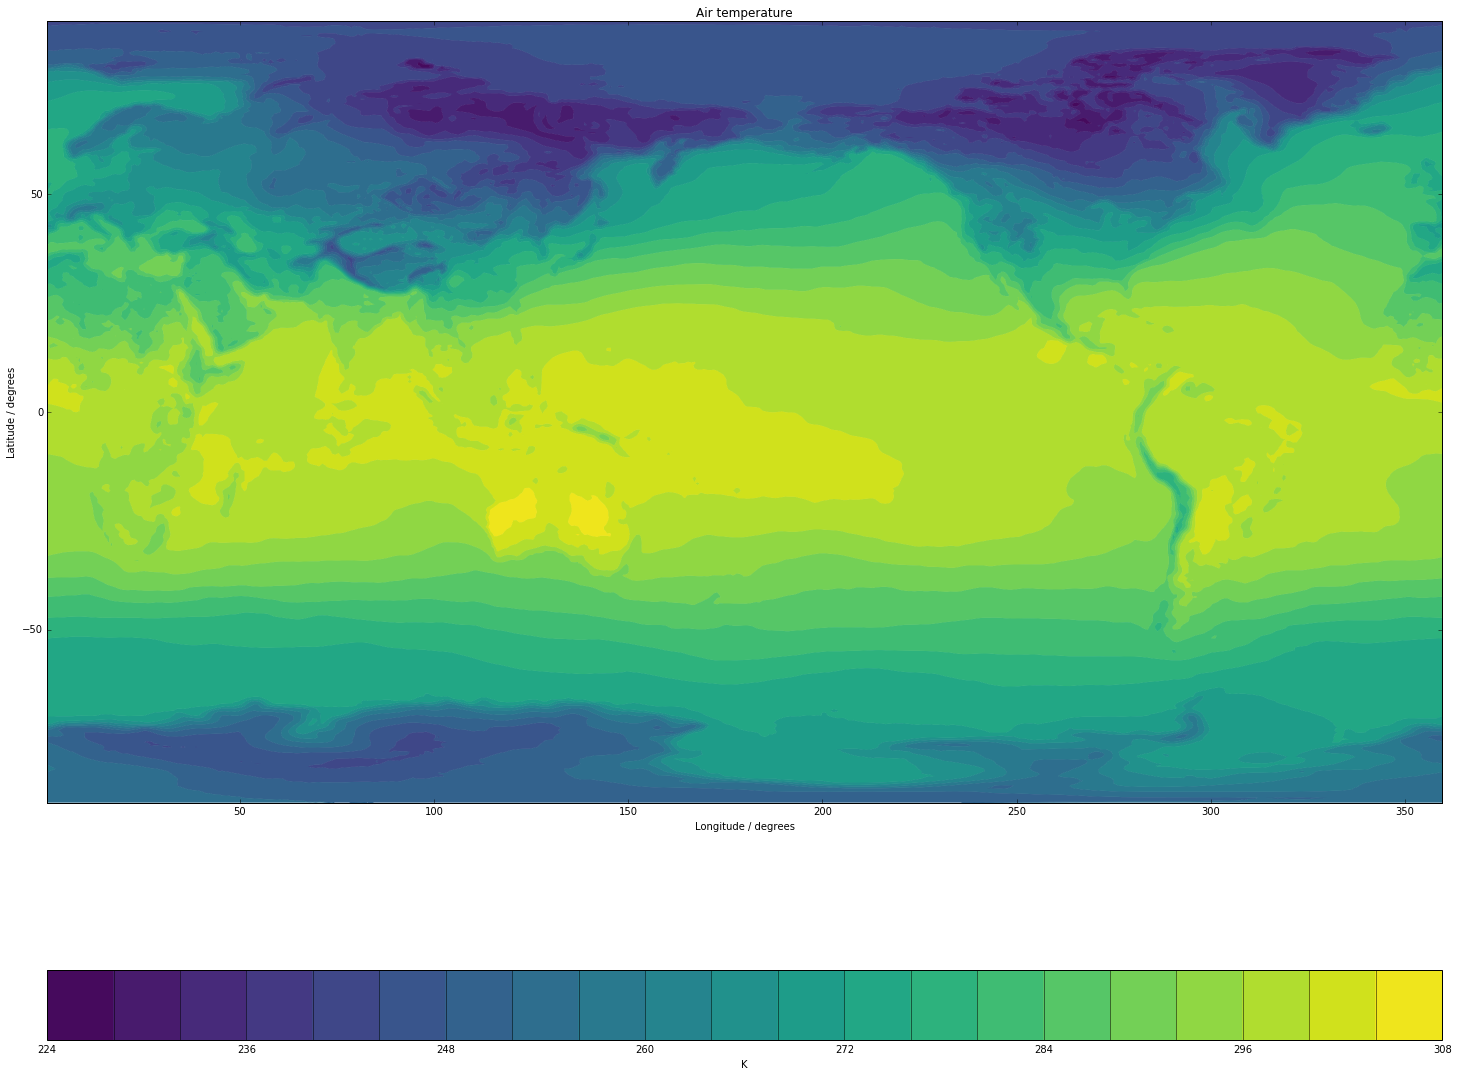

In [15]:
# Lets plot some of that data
qplt.contourf(cube[0,0,:,:], 25)

# Add coastlines to the map created by contourf.
plt.show()

In [16]:
%%time
# BG want this demonstrated for a live TB size data set....
# Their us case is accessing one point for all model runs for a give validity time, the below is equivilant(ish)
print(cube[:,7,45,45].data)

[255.76514 261.56274 257.761   256.89673 259.90332 257.9912  255.09326
 260.15503 258.03906 261.06396 258.75757 258.75293 258.84692 257.0398
 255.44507]
CPU times: user 1.48 s, sys: 1.24 s, total: 2.72 s
Wall time: 16.5 s


In [17]:
uk_constraint = iris.Constraint(latitude=lambda cell: 49.8 < cell < 59.5, longitude=lambda cell: -10.9 < cell < 2.0)
uk_mean = (cube.extract(uk_constraint).collapsed('physics', iris.analysis.MEAN)
                                    .collapsed('latitude', iris.analysis.MEAN)
                                    .collapsed('longitude', iris.analysis.MEAN))
uk_mean

/opt/conda/lib/python3.6/site-packages/iris/coords.py:1162: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(self.dtype, np.str):
/opt/conda/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'physics'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.6/site-packages/iris/cube.py:3146: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/conda/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/conda/lib/python3.6/site-packages/iris/coords.py:1191: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptiv

<iris 'Cube' of air_temperature / (K) (time: 648)>

We should get advantages if we use a cluster

In [18]:
from dask_kubernetes import KubeCluster
import distributed
cluster = KubeCluster()
cluster

VBox(children=(HTML(value='<b>Dashboard:</b> <a href="/user/tam203/proxy/8787/status" target="_blank">/user/tam203/proxy/8787/status</a>'), IntText(value=0, description='Requested', layout=Layout(width='150px')), Text(value='0', description='Actual', layout=Layout(width='150px')), Button(description='Scale', layout=Layout(width='150px'), style=ButtonStyle())))

In [19]:
client = distributed.Client(cluster.scheduler_address)
client

Client Scheduler: tcp://100.97.88.15:46453 Dashboard: http://100.97.88.15:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [20]:
%%timeit
print(cube[:,6,45,45].data)

[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 262.7544  263.33374 262.9563  263.76172 259.82886 266.02808
 262.93994]
[259.53564 259.88037 261.4026  263.83667 263.87793 260.1936  263.7339
 261.77856 2

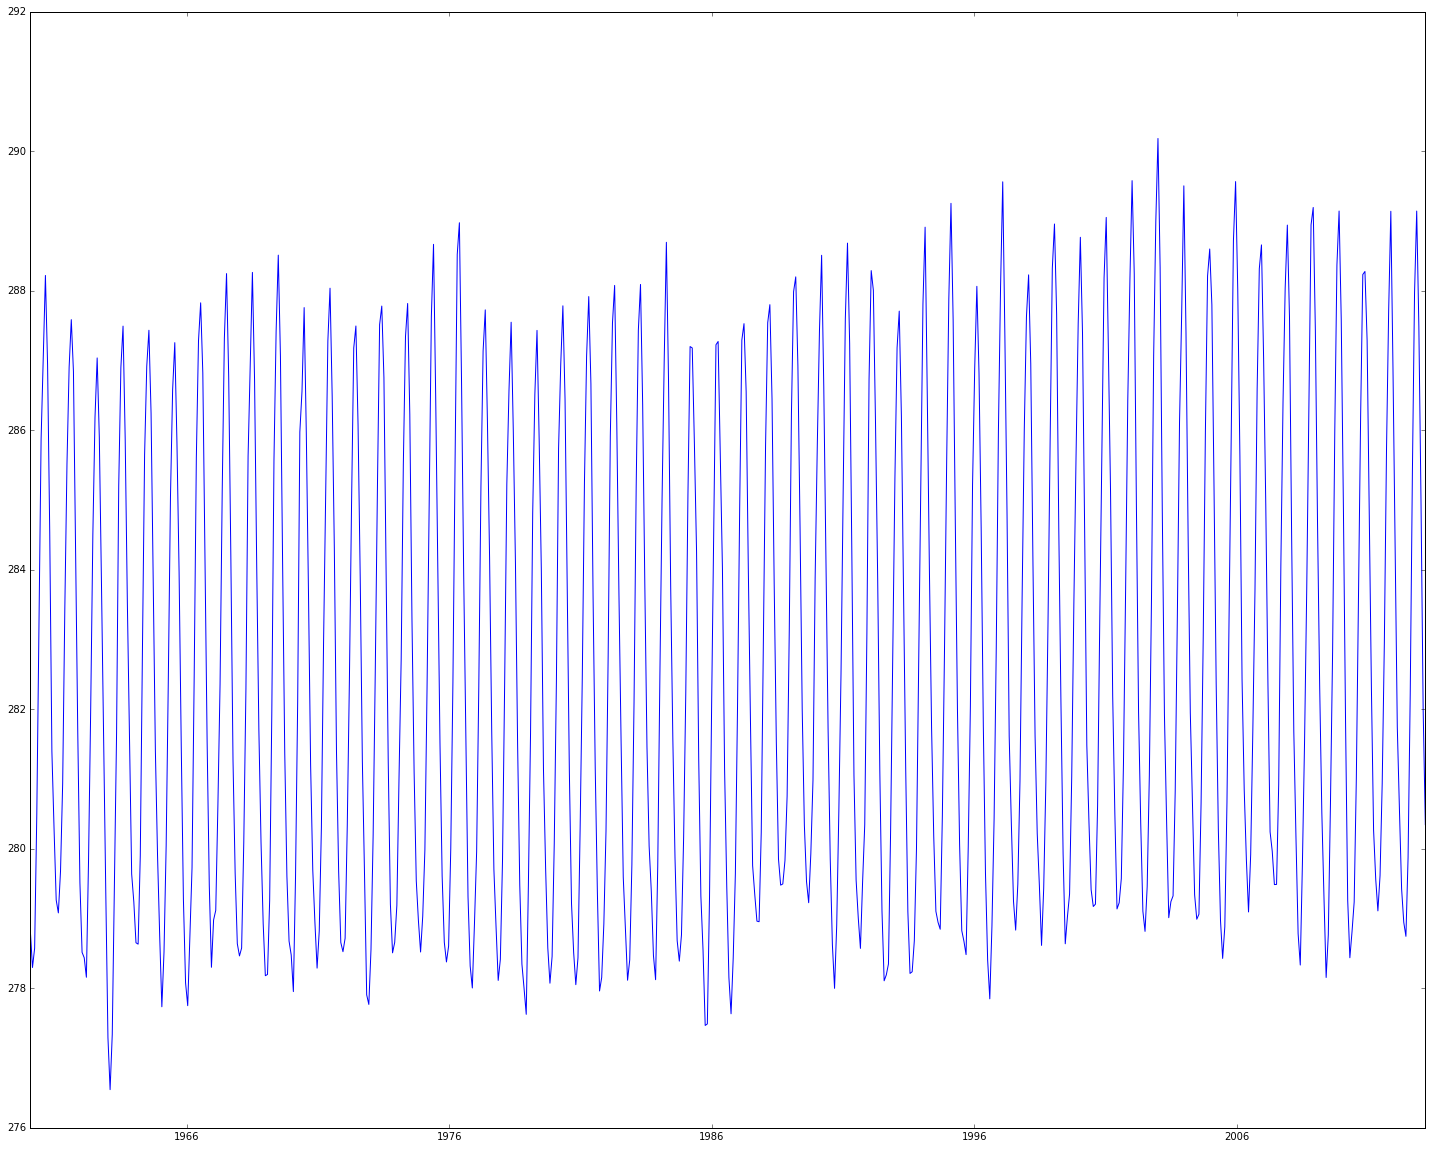

In [21]:
iplt.plot(uk_mean)
plt.show()